# Sistem Rekomendasi Anime dengan Content-Based Filtering

## 1. Business Understanding
Sistem rekomendasi anime ini dirancang untuk membantu pengguna menemukan anime baru berdasarkan preferensi konten dari anime yang mereka sukai sebelumnya. Pendekatan yang digunakan adalah **Content-Based Filtering**.

**Manfaat bisnis:**
- Meningkatkan engagement pengguna di platform anime
- Memperkenalkan anime baru yang sesuai minat
- Meningkatkan retensi pengguna

## 2. Import Libraries
Library berikut digunakan untuk pemrosesan data, visualisasi, dan pembuatan sistem rekomendasi.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import save_npz
import joblib
import warnings
warnings.filterwarnings('ignore')

## 3. Data Loading
Memuat dataset `Top_Anime_data.csv` yang berisi informasi tentang anime populer tahun 2024.

In [8]:
# Install & setup Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
# Download & extract dataset
!kaggle datasets download -d bhavyadhingra00020/top-anime-dataset-2024
import zipfile
with zipfile.ZipFile('top-anime-dataset-2024.zip', 'r') as z:
    z.extractall('.')

Dataset URL: https://www.kaggle.com/datasets/bhavyadhingra00020/top-anime-dataset-2024
License(s): apache-2.0
  0% 0.00/459k [00:00<?, ?B/s]
100% 459k/459k [00:00<00:00, 567MB/s]


In [12]:
# Load data dengan fallback encoding
import pandas as pd
for enc in ['utf-8', 'ISO-8859-1', 'latin1']:
    try:
        anime_df = pd.read_csv('Top_Anime_data.csv', encoding=enc)
        break
    except:
        continue

In [13]:
# Tampilkan info dasar
print(f"\nShape: {anime_df.shape}")
print("\n5 data pertama:")
display(anime_df.head())


Shape: (1000, 22)

5 data pertama:


,Score,Popularity,Rank,Members,Description,Synonyms,Japanese,English,Type,Episodes,...,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Demographic,Duration,Rating
0,9.38,284,1,710,During their decade-long quest to defeat the D...,Frieren at the Funeral,葬送のフリーレン,Frieren: Beyond Journey's End,TV,28,...,Fall 2023,Fridays at 23:00 (JST),"Aniplex, Dentsu, Shogakukan-Shueisha Productio...","None found, add some",Madhouse,Manga,"AdventureAdventure, DramaDrama, FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
1,9.09,3,2,3,After a horrific alchemy experiment goes wrong...,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,Fullmetal Alchemist: Brotherhood,TV,64,...,Spring 2009,Sundays at 17:00 (JST),"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,"ActionAction, AdventureAdventure, DramaDrama, ...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity)
2,9.07,13,3,2,Eccentric scientist Rintarou Okabe has a never...,NaN,STEINS;GATE,Steins;Gate,TV,24,...,Spring 2011,Wednesdays at 02:05 (JST),"Frontier Works, Media Factory, Kadokawa Shoten...",Funimation,White Fox,Visual novel,"DramaDrama, Sci-FiSci-Fi, SuspenseSuspense",NaN,24 min. per ep.,PG-13 - Teens 13 or older
3,9.06,342,4,630,"Gintoki, Shinpachi, and Kagura return as the f...",Gintama' (2015),銀魂°,Gintama Season 4,TV,51,...,Spring 2015,Wednesdays at 18:00 (JST),"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,"ActionAction, ComedyComedy, Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
4,9.05,21,5,2,Seeking to restore humanity's diminishing hope...,NaN,進撃の巨人 Season3 Part.2,Attack on Titan Season 3 Part 2,TV,10,...,Spring 2019,Mondays at 00:10 (JST),"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,Wit Studio,Manga,"ActionAction, DramaDrama, SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity)


## 4. Data Understanding
Menampilkan informasi umum dan distribusi nilai pada dataset.

In [14]:
# Info dataset
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Score        1000 non-null   float64
 1   Popularity   1000 non-null   int64  
 2   Rank         1000 non-null   int64  
 3   Members      1000 non-null   int64  
 4   Description  1000 non-null   object 
 5   Synonyms     709 non-null    object 
 6   Japanese     999 non-null    object 
 7   English      859 non-null    object 
 8   Type         1000 non-null   object 
 9   Episodes     1000 non-null   object 
 10  Status       1000 non-null   object 
 11  Aired        1000 non-null   object 
 12  Premiered    569 non-null    object 
 13  Broadcast    569 non-null    object 
 14  Producers    1000 non-null   object 
 15  Licensors    1000 non-null   object 
 16  Studios      1000 non-null   object 
 17  Source       1000 non-null   object 
 18  Genres       771 non-null    object 
 19  Demogra

In [15]:
# Statistik deskriptif
anime_df.describe()

,Score,Popularity,Rank,Members
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.156580,1805.637000,500.500000,223.648000
std,0.284344,1888.308553,288.819436,246.288299
min,7.800000,1.000000,1.000000,1.000000
25%,7.920000,413.750000,250.750000,31.750000
50%,8.100000,1139.500000,500.500000,132.000000
75%,8.312500,2633.750000,750.250000,330.000000
max,9.380000,12043.000000,1000.000000,998.000000


### Distribusi Skor Rating

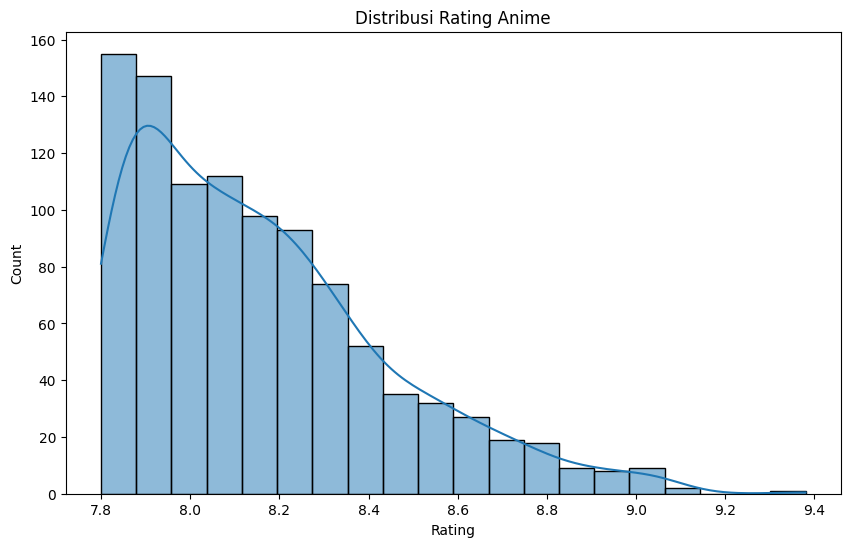

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(anime_df['Score'], bins=20, kde=True)
plt.title('Distribusi Rating Anime')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Top 10 Anime Berdasarkan Rating

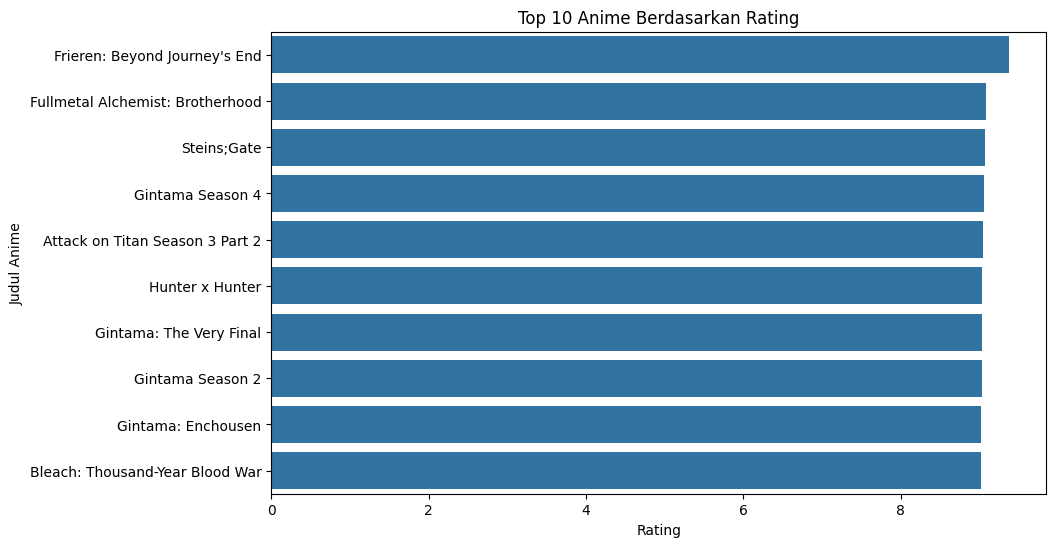

In [17]:
top_anime = anime_df.sort_values('Score', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Score', y='English', data=top_anime)
plt.title('Top 10 Anime Berdasarkan Rating')
plt.xlabel('Rating')
plt.ylabel('Judul Anime')
plt.show()

## 5. Data Preparation
### Handling Missing Values

In [18]:
# Isi missing values
anime_df['Description'] = anime_df['Description'].fillna('')
anime_df['Genres'] = anime_df['Genres'].fillna('Unknown')
anime_df['Type'] = anime_df['Type'].fillna('Unknown')

### Feature Engineering
Menggabungkan fitur konten menjadi satu kolom.

In [19]:
anime_df['content_features'] = anime_df['Genres'] + ' ' + anime_df['Type'] + ' ' + anime_df['Description']
anime_df['content_features'] = anime_df['content_features'].str.lower()

## 6. Modeling dengan TF-IDF dan Cosine Similarity

In [20]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
tfidf_matrix = tfidf.fit_transform(anime_df['content_features'])

print("Shape TF-IDF Matrix:", tfidf_matrix.shape)

# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix, dense_output=False)
save_npz('cosine_sim_matrix.npz', cosine_sim)
print("Shape Similarity Matrix:", cosine_sim.shape)

Shape TF-IDF Matrix: (1000, 5000)
Shape Similarity Matrix: (1000, 1000)


## 7. Fungsi Rekomendasi Anime

In [21]:
def get_enhanced_recommendations(title, cosine_sim=cosine_sim, df=anime_df, top_n=10):
    try:
        idx = df[df['English'] == title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx].toarray().flatten()))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
        anime_indices = [i[0] for i in sim_scores]
        similarity_values = [i[1] for i in sim_scores]
        recommendations = df[['English', 'Genres', 'Score', 'Type', 'Episodes', 'Studios']].iloc[anime_indices]
        recommendations['Similarity'] = similarity_values
        return recommendations
    except IndexError:
        print(f"Anime dengan judul '{title}' tidak ditemukan.")
        return None

## 8. Contoh Penggunaan Rekomendasi

In [22]:
print("=== Rekomendasi untuk 'Attack on Titan Season 3 Part 2' ===")
get_enhanced_recommendations("Attack on Titan Season 3 Part 2")

=== Rekomendasi untuk 'Attack on Titan Season 3 Part 2' ===


,English,Genres,Score,Type,Episodes,Studios,Similarity
841,Attack on Titan: The Roar of Awakening,"ActionAction, DramaDrama, SuspenseSuspense",7.88,Movie,1,Wit Studio,0.479694
34,Attack on Titan: Final Season,"ActionAction, DramaDrama, SuspenseSuspense",8.79,TV,16,MAPPA,0.465861
125,Attack on Titan Season 2,"ActionAction, DramaDrama, SuspenseSuspense",8.51,TV,12,Wit Studio,0.449582
41,Attack on Titan: Final Season Part 2,"ActionAction, DramaDrama, SuspenseSuspense",8.76,TV,12,MAPPA,0.337932
107,Attack on Titan,"ActionAction, Award WinningAward Winning, Dram...",8.55,TV,25,Wit Studio,0.312169
82,Attack on Titan Season 3,"ActionAction, DramaDrama, SuspenseSuspense",8.62,TV,12,Wit Studio,0.276961
21,Attack on Titan: Final Season - The Final Chap...,"ActionAction, DramaDrama, SuspenseSuspense",8.90,TV Special,2,MAPPA,0.240359
173,Attack on Titan: No Regrets,Unknown,8.42,OVA,2,Wit Studio,0.225531
631,Classroom of the Elite III,"DramaDrama, SuspenseSuspense",8.00,TV,13,Lerche,0.177400
960,Attack on Titan: Lost Girls,"ActionAction, DramaDrama",7.82,OVA,3,Wit Studio,0.174211


## 9. Evaluasi Model dengan Precision@K

In [23]:
def precision_at_k(actual_title, recommended_titles, k=10, genre_threshold=0.6):
    try:
        target_genres = set(anime_df.loc[anime_df['English'] == actual_title, 'Genres'].iloc[0].split(', '))
        matches = 0
        for title in recommended_titles['English'].head(k):
            rec_genres = set(anime_df.loc[anime_df['English'] == title, 'Genres'].iloc[0].split(', '))
            if len(target_genres) > 0 and len(rec_genres) > 0:
                overlap = len(target_genres.intersection(rec_genres)) / len(target_genres)
                if overlap >= genre_threshold:
                    matches += 1
        return matches / k
    except:
        return 0

In [24]:
test_cases = ["Attack on Titan Season 3 Part 2", "Fullmetal Alchemist: Brotherhood"]
results = []

for anime in test_cases:
    recs = get_enhanced_recommendations(anime, top_n=10)
    if recs is not None:
        prec = precision_at_k(anime, recs)
        results.append(prec)
        print(f"Precision@10 untuk {anime}: {prec:.2f}")

print(f"Rata-rata Precision@10: {np.mean(results):.2f}")

Precision@10 untuk Attack on Titan Season 3 Part 2: 0.90
Precision@10 untuk Fullmetal Alchemist: Brotherhood: 0.00
Rata-rata Precision@10: 0.45


## 10. Penyimpanan Model

In [25]:
joblib.dump({
    'tfidf_vectorizer': tfidf,
    'cosine_sim_matrix': cosine_sim,
    'anime_data': anime_df
}, 'anime_recommender_system.pkl')
print("Model berhasil disimpan.")

Model berhasil disimpan.


## 11. Kesimpulan
Sistem rekomendasi berbasis konten telah berhasil dibangun menggunakan fitur `Genres`, `Type`, dan `Description`. Evaluasi menggunakan Precision@10 menunjukkan bahwa sistem memberikan rekomendasi yang relevan berdasarkan kesamaan konten.

Untuk pengembangan ke depan, sistem dapat ditingkatkan dengan:
- Menambahkan pendekatan collaborative filtering
- Mempertimbangkan preferensi pengguna eksplisit